# Updated PCA

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('Data/default of credit card clients.csv')
df.rename(columns={'Default':'default'}, inplace=True)
df.index = df.ID
if 'ID' in df:
    del df['ID']
    
 
df["log_LIMIT_BAL"]=np.log(df.LIMIT_BAL)
df["log_PAY_AMT1"]=np.log(df.PAY_AMT1+1)
df["log_PAY_AMT2"]=np.log(df.PAY_AMT2+1)
df["log_PAY_AMT3"]=np.log(df.PAY_AMT3+1)
df["log_PAY_AMT4"]=np.log(df.PAY_AMT4+1)
df["log_PAY_AMT5"]=np.log(df.PAY_AMT5+1)
df["log_PAY_AMT6"]=np.log(df.PAY_AMT6+1)

from sklearn.decomposition import PCA
pca=PCA(n_components=4)
X=df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
X_pca = pca.fit(X).transform(X)
print ('pca:', pca.components_)

pca: [[ 0.44758414  0.44176541  0.42968661  0.39797914  0.36991877  0.35306357]
 [ 0.55364282  0.39161138  0.07512402 -0.26727471 -0.45057905 -0.50992086]
 [-0.44992027 -0.03350715  0.71786681  0.29121344 -0.17374957 -0.40758078]
 [-0.19281276  0.16883483  0.41377134 -0.70645473 -0.1561488   0.4895412 ]]


In [2]:
from sklearn.preprocessing import StandardScaler
features = ['BILL_AMT1', 'BILL_AMT2','BILL_AMT3','BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
x = df.loc[:, features].values
y = df.loc[:,['default']].values
x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

C:\Users\otany\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,principal component 1,principal component 2
0,-1.611148,0.012479
1,-1.547595,-0.062344
2,-1.035874,0.011256
3,-0.250712,0.174374
4,-0.968951,-0.213032


In [3]:
pca.explained_variance_ratio_

array([ 0.90555253,  0.0509867 ])

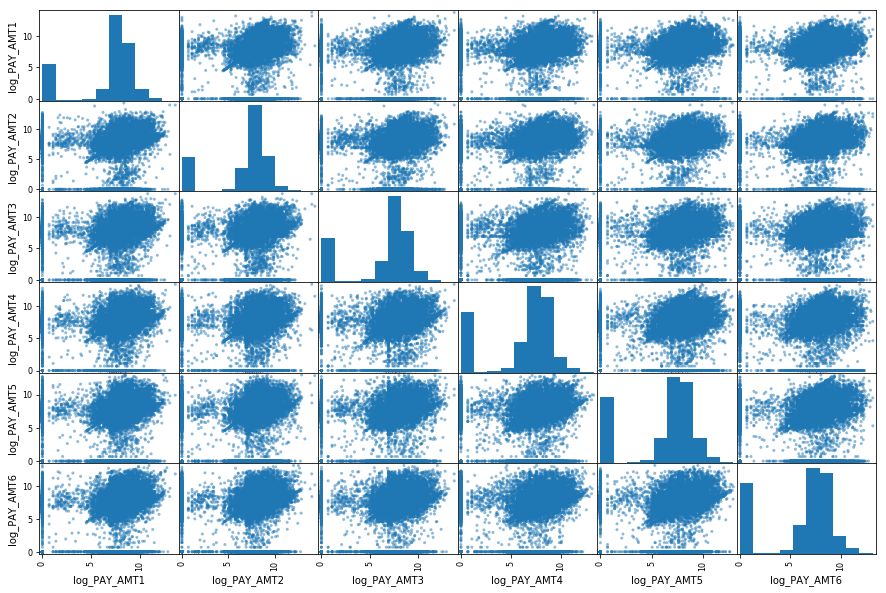

In [4]:
from pandas.plotting import scatter_matrix
%matplotlib inline
ax = scatter_matrix(df[["log_PAY_AMT1","log_PAY_AMT2","log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5","log_PAY_AMT6"]],figsize=(15,10))


After log transformation of PAY_AMTs, we do not need to include them to PCA, since no strong correlation were seen on plots above.

##### Training and Testing Split

For training and testing purposes, let's gather the data we have and grab 80% of the instances for training and the remaining 20% for testing. Moreover, let's repeat this process of separating the testing and training data five times. We will use the hold out cross validation method built into scikit-learn.

In [5]:
# perform one-hot encoding of the categorical data "EDUCATION" and "MARRIAGE".
tmp_df_1 = pd.get_dummies(df.EDUCATION,prefix='EDUCATION')
tmp_df_2 = pd.get_dummies(df.MARRIAGE,prefix='MARRIAGE')
df_imputed = pd.concat((df,tmp_df_1,tmp_df_2),axis=1)


In [6]:
Part_of_df_1 = df_imputed[['SEX','EDUCATION_1','EDUCATION_2','EDUCATION_3','EDUCATION_4','EDUCATION_5','EDUCATION_6', 'MARRIAGE_0',
                         'MARRIAGE_1','MARRIAGE_2','MARRIAGE_3','AGE', 'default','PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                           'PAY_6', "log_LIMIT_BAL","log_PAY_AMT1","log_PAY_AMT2",
                         "log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5","log_PAY_AMT6"]]
#finalDf.loc[0] = 'NaN'
principalDf.index = np.arange(1, len(df) + 1)
final_Data_Frame_1 = pd.concat([principalDf, Part_of_df_1], axis=1)


In [8]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'default' in final_Data_Frame_1:
    y = final_Data_Frame_1['default'].values # get the labels we want
    del final_Data_Frame_1['default'] # get rid of the class label
    X = final_Data_Frame_1.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 5
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)


ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=None)


# Support Vector Machines

In [23]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
from sklearn.preprocessing import StandardScaler

scl_obj = StandardScaler()

for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [53]:
# lets investigate SVMs on the data
from sklearn.svm import SVC
from sklearn import metrics as mt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=5, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('Accuracy:', acc )
print('Confusion matrix:')
print(conf)
print('f1_score:', f1_score(y_test, y_hat))
print('Precision:', precision_score(y_test, y_hat))
print('Recall:', recall_score(y_test, y_hat)) 

accuracy: 0.825
confusion matrix:
[[4500  196]
 [ 854  450]]
f1_score: 0.461538461538
Precision: 0.696594427245
Recall: 0.34509202454


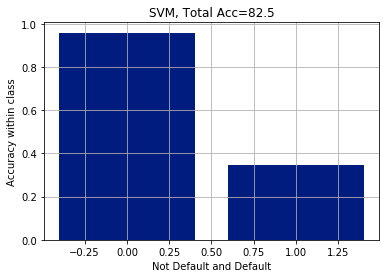

In [49]:
from matplotlib import pyplot as plt

def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Not Default and Default')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.show()
    
plot_class_acc(y_test,y_hat,title="SVM")  

# KNN

KNN accuracy 0.697
Accuracy: 0.825
Confusion matrix:
[[3974  722]
 [1096  208]]
f1_score: 0.186213070725
Precision: 0.223655913978
Recall: 0.159509202454


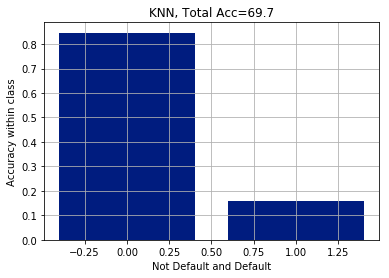

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt


# create cross validation iterator
cv = StratifiedKFold(n_splits=10)

# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=3)

# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
for train, test in cv_object.split(X,y):
    clf.fit(X[train],y[train])
    yhat = clf.predict(X[test])

total_accuracy = mt.accuracy_score(y_test, yhat)
print ('KNN accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat)
print('Accuracy:', acc )
print('Confusion matrix:')
print(conf)
print('f1_score:', f1_score(y_test, yhat))
print('Precision:', precision_score(y_test, yhat))
print('Recall:', recall_score(y_test, yhat))  
plot_class_acc(y_test,yhat,title="KNN") 

# Random Forest

Accuracy 0.715666666667
Confusion matrix:
[[4126  570]
 [1136  168]]
f1_score: 0.164544564153
Precision: 0.227642276423
Recall: 0.128834355828


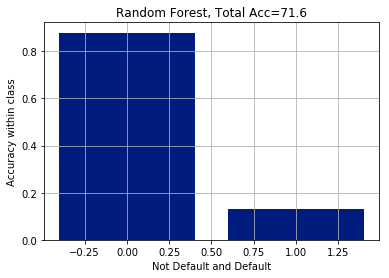

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

clf = RandomForestClassifier(max_depth=100, n_estimators=300, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv_object.split(X,y):
    clf.fit(X[train],y[train])
    yhat = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y_test, yhat)
print ('Accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat)
print('Confusion matrix:')
print(conf)
print('f1_score:', f1_score(y_test, yhat))
print('Precision:', precision_score(y_test, yhat))
print('Recall:', recall_score(y_test, yhat)) 
plot_class_acc(y_test,yhat,title="Random Forest")
